In [11]:
import random
from itertools import combinations
import pandas as pd
import numpy as np

import math
from collections import defaultdict, Counter
from typing import List, Dict, Tuple

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score, f1_score


# Визуализация
import matplotlib.pyplot as plt
try:
    from sklearn.manifold import TSNE
    HAS_TSNE = True
except Exception:
    from sklearn.decomposition import PCA
    HAS_TSNE = False

In [ ]:
#генерим граф по sbm далее сплттим на трейн
#и тест положительных ребер и подбираем сбалансирвоанные отрицательные пары


In [3]:
random.seed(42)

n = 300                 
k = 3                  
sizes = [n // k] * (k - 1) + [n - (n // k) * (k - 1)]  
p_in = 0.08             
p_out = 0.01            
train_ratio = 0.7       


communities = []
start = 0
for c, sz in enumerate(sizes):
    for node in range(start, start + sz):
        communities.append((node, c))
    start += sz

nodes_df = pd.DataFrame(communities, columns=["node_id", "community"])
node_to_comm = dict(communities)

edges = []
for u in range(n):
    cu = node_to_comm[u]
    for v in range(u + 1, n):
        cv = node_to_comm[v]
        p = p_in if cu == cv else p_out
        if random.random() < p:
            edges.append((u, v))

adjacency_df = pd.DataFrame(edges, columns=["u", "v"])

edge_set = set(edges)
nonedges = []
for u in range(n):
    for v in range(u + 1, n):
        if (u, v) not in edge_set:
            nonedges.append((u, v))

random.shuffle(edges)
random.shuffle(nonedges)

pos_train_size = int(len(edges) * train_ratio)
edges_train = edges[:pos_train_size]
edges_test  = edges[pos_train_size:]

neg_train_size = len(edges_train)
neg_test_size  = len(edges_test)

nonedges_train = nonedges[:neg_train_size]
nonedges_test  = nonedges[neg_train_size:neg_train_size + neg_test_size]


edges_train_df = pd.DataFrame(edges_train, columns=["u", "v"])
edges_train_df["label"] = 1

edges_test_df = pd.DataFrame(edges_test, columns=["u", "v"])
edges_test_df["label"] = 1

nonedges_train_df = pd.DataFrame(nonedges_train, columns=["u", "v"])
nonedges_train_df["label"] = 0

nonedges_test_df = pd.DataFrame(nonedges_test, columns=["u", "v"])
nonedges_test_df["label"] = 0


print("Nodes:", len(nodes_df))
print("Communities:", sizes)
print("Edges total:", len(adjacency_df))
print("Train pos:", len(edges_train_df), "| Test pos:", len(edges_test_df))
print("Train neg:", len(nonedges_train_df), "| Test neg:", len(nonedges_test_df))

# Small previews (optional)
print("\nnodes_df.head():")
print(nodes_df.head())
print("\nadjacency_df.head():")
print(adjacency_df.head())
print("\nedges_train_df.head():")
print(edges_train_df.head())
print("\nnonedges_train_df.head():")
print(nonedges_train_df.head())


Nodes: 300
Communities: [100, 100, 100]
Edges total: 1549
Train pos: 1084 | Test pos: 465
Train neg: 1084 | Test neg: 465

nodes_df.head():
   node_id  community
0        0          0
1        1          0
2        2          0
3        3          0
4        4          0

adjacency_df.head():
   u   v
0  0   2
1  0  10
2  0  13
3  0  20
4  0  42

edges_train_df.head():
     u    v  label
0  156  170      1
1  156  167      1
2  247  255      1
3  248  289      1
4  215  298      1

nonedges_train_df.head():
     u    v  label
0  291  299      0
1  117  186      0
2   61  198      0
3   71  105      0
4  171  235      0


In [12]:
# Сбор структуры графа: соседи, степени, распределение для негативов
def build_graph_structures(adjacency_df: pd.DataFrame, n_nodes: int):
    """Возвращает соседи, степени, множество ребер, и dist1 (для node2vec проверок)."""
    neighbors = [[] for _ in range(n_nodes)]
    deg = np.zeros(n_nodes, dtype=np.int64)
    edge_set = set()

    for u, v in adjacency_df[["u","v"]].itertuples(index=False):
        neighbors[u].append(v)
        neighbors[v].append(u)
        deg[u] += 1
        deg[v] += 1
        edge_set.add((u, v))
        edge_set.add((v, u))   # для удобной проверки смежности

    # для node2vec нам нужно быстро проверять, является ли x соседом t (dist=1)
    # организуем как множества соседей
    neighbors_set = [set(lst) for lst in neighbors]

    # распределение для negative sampling: degree**0.75
    neg_dist = np.power(np.maximum(deg, 1), 0.75).astype(np.float64)
    neg_dist = neg_dist / neg_dist.sum()

    return neighbors, neighbors_set, deg, neg_dist, edge_set

In [ ]:
#DeepWalk блуждания
def deepwalk_random_walks(
    neighbors: List[List[int]],
    num_walks_per_node: int = 10,
    walk_length: int = 80,
    seed: int = 42
) -> List[List[int]]:
    rng = random.Random(seed)
    n = len(neighbors)
    walks = []
    order = list(range(n))
    for _ in range(num_walks_per_node):
        rng.shuffle(order)
        for start in order:
            if not neighbors[start]:
                continue
            path = [start]
            cur = start
            for _ in range(walk_length - 1):
                nxt = rng.choice(neighbors[cur]) if neighbors[cur] else cur
                path.append(nxt)
                cur = nxt
            walks.append(path)
    return walks

In [ ]:
#Node2Vec
def node2vec_random_walks(
    neighbors: List[List[int]],
    neighbors_set: List[set],
    p: float = 1.0,
    q: float = 1.0,
    num_walks_per_node: int = 10,
    walk_length: int = 80,
    seed: int = 43
) -> List[List[int]]:
    """
    Правила из статьи node2vec:
      - Пусть предыдущая вершина t, текущая v, кандидат в шаг x
      - Взвешивание:
          * w = 1/p     если x == t   (возврат)
          * w = 1       если (t,x) 
          * w = 1/q     иначе (dist=2)
    Затем нормируем веса и сэмплируем следующий x
    """
    rng = random.Random(seed)
    n = len(neighbors)
    walks = []
    order = list(range(n))

    for _ in range(num_walks_per_node):
        rng.shuffle(order)
        for start in order:
            if not neighbors[start]:
                continue
            path = [start]
            # первый шаг: как в обычном RW
            cur = start
            nxt = rng.choice(neighbors[cur]) if neighbors[cur] else cur
            path.append(nxt)

            for _ in range(walk_length - 2):
                t = path[-2]   # previous
                v = path[-1]   # current
                cand = neighbors[v]
                if not cand:
                    path.append(v)
                    continue

                weights = []
                for x in cand:
                    if x == t:
                        w = 1.0 / p
                    elif x in neighbors_set[t]:  # dist=1
                        w = 1.0
                    else:
                        w = 1.0 / q
                    weights.append(w)

                # нормировка и выбор
                s = sum(weights)
                probs = [w/s for w in weights]
                # выбор по распределению probs
                r = rng.random()
                cum = 0.0
                chosen = cand[-1]
                for x, pr in zip(cand, probs):
                    cum += pr
                    if r <= cum:
                        chosen = x
                        break
                path.append(chosen)
            walks.append(path)
    return walks

In [15]:
# 3) Skip-gram пары (центр–контекст) из путей с окном w
def build_skipgram_pairs(walks: List[List[int]], window: int = 10) -> Counter:
    counts = Counter()
    for path in walks:
        L = len(path)
        for i, u in enumerate(path):
            left = max(0, i - window)
            right = min(L - 1, i + window)
            for j in range(left, right + 1):
                if j == i:
                    continue
                v = path[j]
                counts[(u, v)] += 1
    return counts

In [16]:
class SkipGramDataset(torch.utils.data.IterableDataset):
    def __init__(
        self,
        pair_counts: Counter,
        n_nodes: int,
        neg_dist: np.ndarray,
        negatives_k: int = 5,
        repeat_factor: float = 1.0,
        seed: int = 123
    ):
        self.n_nodes = n_nodes
        self.neg_dist = neg_dist
        self.negatives_k = negatives_k
        self.rng = np.random.default_rng(seed)

        pairs = []
        for (u, v), c in pair_counts.items():
            pairs.extend([(u, v)] * c)  # эмпирические частоты как повторы
        self.pairs = np.array(pairs, dtype=np.int64)

        if repeat_factor != 1.0 and len(self.pairs) > 0:
            take = int(len(self.pairs) * repeat_factor)
            idx = self.rng.integers(0, len(self.pairs), size=max(take, 1))
            self.pairs = self.pairs[idx]

        self.prob = self.neg_dist

    def __iter__(self):
        if len(self.pairs) == 0:
            return iter([])
        idx = self.rng.permutation(len(self.pairs))
        for i in idx:
            u, v = self.pairs[i]
            negs = self.rng.choice(self.n_nodes, size=self.negatives_k, replace=True, p=self.prob)
            yield u, v, negs

# ---------------------------
# 5) Модель SGNS
# ---------------------------
class SkipGramNS(nn.Module):
    def __init__(self, n_nodes: int, dim: int):
        super().__init__()
        self.in_emb = nn.Embedding(n_nodes, dim)
        self.out_emb = nn.Embedding(n_nodes, dim)
        nn.init.uniform_(self.in_emb.weight, a=-0.5/dim, b=0.5/dim)
        nn.init.zeros_(self.out_emb.weight)

    def forward(self, centers: torch.Tensor, contexts: torch.Tensor, negatives: torch.Tensor):
        z_u = self.in_emb(centers)          # [B, D]
        z_v = self.out_emb(contexts)        # [B, D]
        z_neg = self.out_emb(negatives)     # [B, K, D]

        s_pos = torch.sum(z_u * z_v, dim=1)               # [B]
        s_neg = torch.sum(z_u.unsqueeze(1) * z_neg, dim=2)  # [B, K]

        loss_pos = -torch.nn.functional.logsigmoid(s_pos)
        loss_neg = -torch.nn.functional.logsigmoid(-s_neg).sum(dim=1)
        loss = (loss_pos + loss_neg).mean()
        return loss

    def get_embeddings(self):
        return self.in_emb.weight.detach().cpu().numpy()


In [17]:
#обучение
def train_embeddings_from_walks(
    walks: List[List[int]],
    n_nodes: int,
    neg_dist: np.ndarray,
    dim: int = 64,
    window: int = 10,
    negatives_k: int = 5,
    batch_size: int = 1024,
    epochs: int = 2,
    lr: float = 0.01,
    seed: int = 7,
):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)

    pair_counts = build_skipgram_pairs(walks, window=window)
    dataset = SkipGramDataset(pair_counts, n_nodes, neg_dist, negatives_k=negatives_k, seed=seed+1)
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = SkipGramNS(n_nodes=n_nodes, dim=dim).to(device)
    opt = optim.Adam(model.parameters(), lr=lr)

    model.train()
    for ep in range(epochs):
        running = 0.0
        steps = 0
        for centers, contexts, negatives in loader:
            centers = centers.to(device)
            contexts = contexts.to(device)
            negatives = negatives.to(device)

            loss = model(centers, contexts, negatives)
            opt.zero_grad(set_to_none=True)
            loss.backward()
            opt.step()

            running += loss.item()
            steps += 1
            if steps % 200 == 0:
                print(f"[epoch {ep+1}] step {steps} | loss {running/200:.4f}")
                running = 0.0
        if steps and (steps % 200 != 0):
            print(f"[epoch {ep+1}] steps {steps} | avg loss {running/max(steps%200,1):.4f}")

    emb = model.get_embeddings()
    return emb

In [18]:
def edge_features(u: np.ndarray, v: np.ndarray, mode="hadamard"):
    """
    u, v: эмбеддинги пар вершин (shape [B, D])
    mode: 'hadamard' (по умолчанию), 'l1', 'l2', 'concat', 'cos'
    """
    if mode == "hadamard":
        return u * v
    elif mode == "l1":
        return np.abs(u - v)
    elif mode == "l2":
        return (u - v) ** 2
    elif mode == "concat":
        return np.concatenate([u, v], axis=1)
    elif mode == "cos":
        nu = u / (np.linalg.norm(u, axis=1, keepdims=True) + 1e-9)
        nv = v / (np.linalg.norm(v, axis=1, keepdims=True) + 1e-9)
        return (nu * nv).sum(axis=1, keepdims=True)
    else:
        raise ValueError("Unknown mode")

def build_edge_dataset(emb: np.ndarray, edges_df: pd.DataFrame, nonedges_df: pd.DataFrame, feat_mode="hadamard"):
    pos = edges_df[["u","v"]].to_numpy()
    neg = nonedges_df[["u","v"]].to_numpy()
    X_pos = edge_features(emb[pos[:,0]], emb[pos[:,1]], mode=feat_mode)
    X_neg = edge_features(emb[neg[:,0]], emb[neg[:,1]], mode=feat_mode)
    X = np.vstack([X_pos, X_neg])
    y = np.concatenate([np.ones(len(X_pos), dtype=int), np.zeros(len(X_neg), dtype=int)])
    return X, y

def train_and_eval_classifier(emb: np.ndarray, edges_train_df, nonedges_train_df, edges_test_df, nonedges_test_df, feat_mode="hadamard", C=1.0):
    X_tr, y_tr = build_edge_dataset(emb, edges_train_df, nonedges_train_df, feat_mode)
    X_te, y_te = build_edge_dataset(emb, edges_test_df, nonedges_test_df, feat_mode)

    clf = LogisticRegression(max_iter=2000, C=C, class_weight=None, n_jobs=None, solver='lbfgs')
    clf.fit(X_tr, y_tr)

    prob = clf.predict_proba(X_te)[:,1]
    pred = (prob >= 0.5).astype(int)

    roc = roc_auc_score(y_te, prob)
    ap  = average_precision_score(y_te, prob)
    acc = accuracy_score(y_te, pred)
    f1  = f1_score(y_te, pred)

    return {"ROC-AUC": roc, "AP": ap, "ACC": acc, "F1": f1}, clf

In [19]:
n_nodes = nodes_df["node_id"].max() + 1
neighbors, neighbors_set, deg, neg_dist, edge_set = build_graph_structures(adjacency_df, n_nodes)

# --- DeepWalk ---
walks_dw = deepwalk_random_walks(
    neighbors,
    num_walks_per_node=5,  # увеличь для качества
    walk_length=40,
    seed=7
)
emb_dw = train_embeddings_from_walks(
    walks=walks_dw,
    n_nodes=n_nodes,
    neg_dist=neg_dist,
    dim=64,
    window=5,
    negatives_k=5,
    batch_size=1024,
    epochs=2,
    lr=0.01,
    seed=7
)

# --- Node2Vec ---
walks_n2v = node2vec_random_walks(
    neighbors=neighbors,
    neighbors_set=neighbors_set,
    p=1.0,     # попробуй p=0.5, q=2.0 (углубление по кластерам) или p=2.0, q=0.5 (обзорные обходы)
    q=1.0,
    num_walks_per_node=5,
    walk_length=40,
    seed=8
)
emb_n2v = train_embeddings_from_walks(
    walks=walks_n2v,
    n_nodes=n_nodes,
    neg_dist=neg_dist,
    dim=64,
    window=5,
    negatives_k=5,
    batch_size=1024,
    epochs=2,
    lr=0.01,
    seed=8
)

# --- Классификация ребер: DeepWalk ---
metrics_dw, clf_dw = train_and_eval_classifier(
    emb=emb_dw,
    edges_train_df=edges_train_df,
    nonedges_train_df=nonedges_train_df,
    edges_test_df=edges_test_df,
    nonedges_test_df=nonedges_test_df,
    feat_mode="hadamard",
    C=1.0
)
print("\n[Edge classifier] DeepWalk features:", metrics_dw)

# --- Классификация ребер: Node2Vec ---
metrics_n2v, clf_n2v = train_and_eval_classifier(
    emb=emb_n2v,
    edges_train_df=edges_train_df,
    nonedges_train_df=nonedges_train_df,
    edges_test_df=edges_test_df,
    nonedges_test_df=nonedges_test_df,
    feat_mode="hadamard",
    C=1.0
)
print("[Edge classifier] Node2Vec features:", metrics_n2v)

# Небольшое резюме
def pretty(m):
    return " | ".join([f"{k}={v:.4f}" for k,v in m.items()])

print("\nSummary:")
print("DeepWalk :", pretty(metrics_dw))
print("Node2Vec:", pretty(metrics_n2v))

[epoch 1] step 200 | loss 2.6745
[epoch 1] step 400 | loss 2.3510
[epoch 1] steps 542 | avg loss 2.3320
[epoch 2] step 200 | loss 2.3078
[epoch 2] step 400 | loss 2.3117
[epoch 2] steps 542 | avg loss 2.3110
[epoch 1] step 200 | loss 2.6722
[epoch 1] step 400 | loss 2.3481
[epoch 1] steps 542 | avg loss 2.3263
[epoch 2] step 200 | loss 2.3011
[epoch 2] step 400 | loss 2.3073
[epoch 2] steps 542 | avg loss 2.3115

[Edge classifier] DeepWalk features: {'ROC-AUC': np.float64(0.9693189964157706), 'AP': np.float64(0.9663968212443568), 'ACC': 0.9053763440860215, 'F1': 0.9073684210526316}
[Edge classifier] Node2Vec features: {'ROC-AUC': np.float64(0.9699063475546306), 'AP': np.float64(0.9690447119811336), 'ACC': 0.9086021505376344, 'F1': 0.9102428722280888}

Summary:
DeepWalk : ROC-AUC=0.9693 | AP=0.9664 | ACC=0.9054 | F1=0.9074
Node2Vec: ROC-AUC=0.9699 | AP=0.9690 | ACC=0.9086 | F1=0.9102


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: divide by zero encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_linea

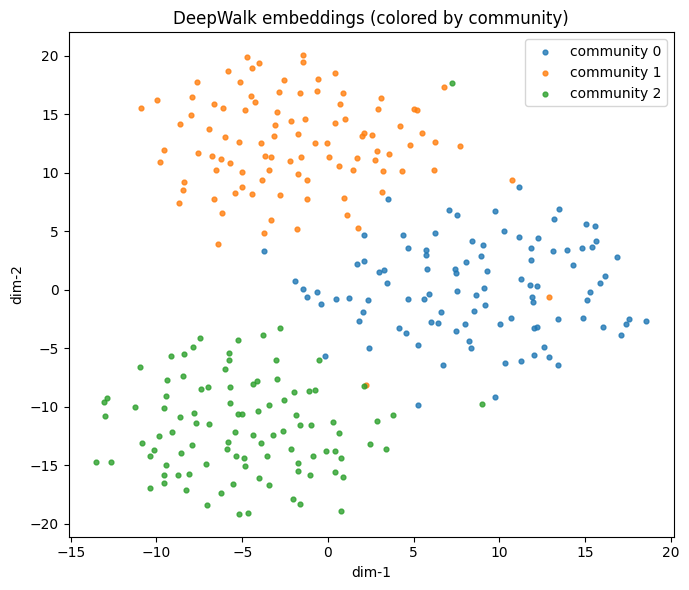

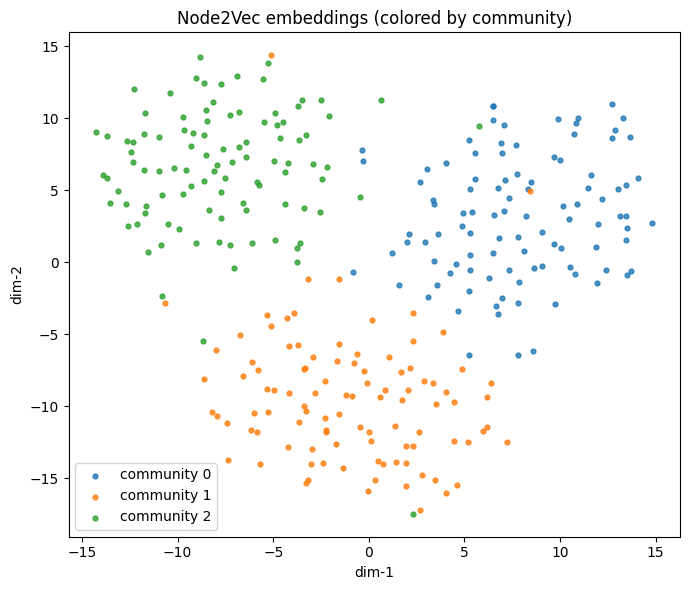

In [ ]:
# попробуем t-SNE, если нет — упадём на PCA
try:
    from sklearn.manifold import TSNE
    def project_2d(X, seed=7):
        return TSNE(n_components=2, init="random", learning_rate="auto",
                    perplexity=30, random_state=seed).fit_transform(X)
except Exception:
    from sklearn.decomposition import PCA
    def project_2d(X, seed=7):
        return PCA(n_components=2, random_state=seed).fit_transform(X)

labels = nodes_df.sort_values("node_id")["community"].to_numpy()

def plot_embeddings(emb, labels, title):
    Z2 = project_2d(emb, seed=7)
    plt.figure(figsize=(7, 6))
    for c in np.unique(labels):
        idx = (labels == c)
        plt.scatter(Z2[idx, 0], Z2[idx, 1], s=12, alpha=0.8, label=f"community {int(c)}")
    plt.title(title)
    plt.xlabel("dim-1"); plt.ylabel("dim-2")
    plt.legend()
    plt.tight_layout()
    plt.show()
plot_embeddings(emb_dw,  labels, title="DeepWalk embeddings (colored by community)")
plot_embeddings(emb_n2v, labels, title="Node2Vec embeddings (colored by community)")
